# Grab Repository data      

In [46]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [47]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/commits_total_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P3', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P9', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P2', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P8', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P1', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/k1bu0cscd4', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/5x4imrvk5b', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P7', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P5', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P14', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/P6', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/bznd2hh7ii', '/Users/annemariewittig/Master/repositoryanalysis/ITS/by_person

In [48]:
# if INTRO_DATE == "":
import json
mapping_file = f"{repository_directories[0]}/mapping.json"
# Check if the file exists
if not os.path.exists(mapping_file):
    print(f"File not found: {mapping_file}. ")
with open(mapping_file, 'r') as f:
    mapping = json.load(f)
print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


Using INTRO_DATE from mapping file: 


# Generate Commit Metrics per Repository

## Amount of Commits over time

In [49]:
commit_result = []
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    commit_file = f"{repository}/commits.csv"
    # Check if the file exists
    if not os.path.exists(commit_file):
        print(f"File not found: {commit_file}. Skipping repository.")
        continue
    commit_df = pd.read_csv(commit_file)
    commit_df = truncate_to_same_length(commit_df, INTRO_DATE, 'date', 'defined', START_DATE, END_DATE)
    commit_df = aggregate_by_date(commit_df, 'date', 'loc_added', 'sum')
    
    pre_release, post_release = split_by_date(commit_df, INTRO_DATE, 'date')

    pre_release_buckets = generate_value_in_buckets(pre_release, 'date', 'count', 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'date', 'count', 'sum', BUCKET_SIZE, 'post-')

    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['count'].to_dict())  # Use 'count' instead of 'value'
    
    commit_result.append(result_row)

# Create the DataFrame
commit_result_df = pd.DataFrame(commit_result)


File not found: /Users/annemariewittig/Master/repositoryanalysis/ITS/by_person/non-participants/commits.csv. Skipping repository.


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_58344/3938441422.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)


In [50]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

columns_order = sort_buckets(commit_result_df, 'pre-', 'post-')
commit_result_df = commit_result_df[columns_order]

In [51]:
commit_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,post-0,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8
0,P3,24.0,37.0,45.0,27.0,21.0,7.0,20.0,7.0,9.0,15.0,3.0,22.0,13.0,24.0,NaN,14.0,18.0,25.0
1,P9,57.0,99.0,30.0,11.0,33.0,46.0,23.0,NaN,37.0,56.0,33.0,36.0,16.0,10.0,NaN,45.0,6.0,17.0
2,P2,10.0,5.0,4.0,16.0,11.0,4.0,NaN,4.0,NaN,40.0,21.0,6.0,31.0,30.0,NaN,16.0,17.0,24.0
3,P8,35.0,18.0,39.0,8.0,40.0,24.0,9.0,28.0,160.0,79.0,49.0,9.0,42.0,38.0,NaN,25.0,79.0,73.0
4,P1,43.0,39.0,29.0,7.0,16.0,20.0,8.0,9.0,5.0,6.0,10.0,4.0,6.0,NaN,4.0,NaN,10.0,12.0
5,k1bu0cscd4,1.0,NaN,2.0,NaN,2.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5x4imrvk5b,78.0,28.0,62.0,10.0,41.0,41.0,49.0,52.0,35.0,49.0,12.0,33.0,39.0,6.0,6.0,35.0,36.0,8.0
7,P7,31.0,32.0,27.0,47.0,31.0,11.0,19.0,9.0,NaN,2.0,20.0,30.0,8.0,4.0,6.0,3.0,7.0,4.0
8,P5,8.0,3.0,6.0,NaN,14.0,20.0,NaN,NaN,NaN,19.0,17.0,16.0,16.0,9.0,1.0,7.0,11.0,5.0
9,P14,45.0,57.0,54.0,14.0,52.0,74.0,35.0,32.0,14.0,62.0,36.0,14.0,6.0,10.0,12.0,40.0,35.0,59.0


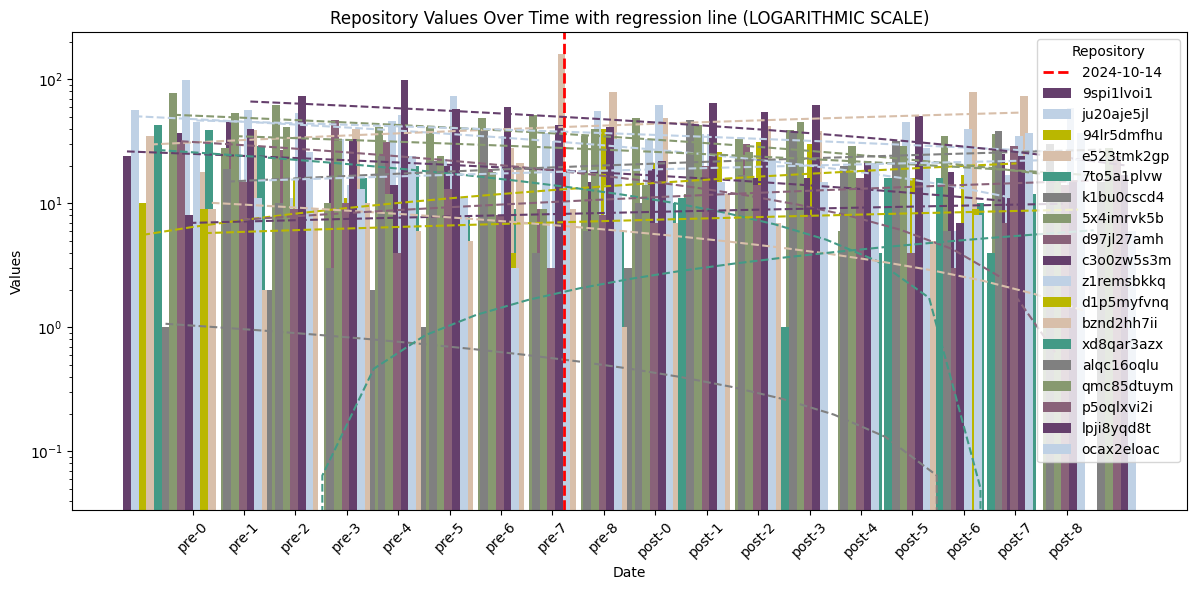

In [52]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

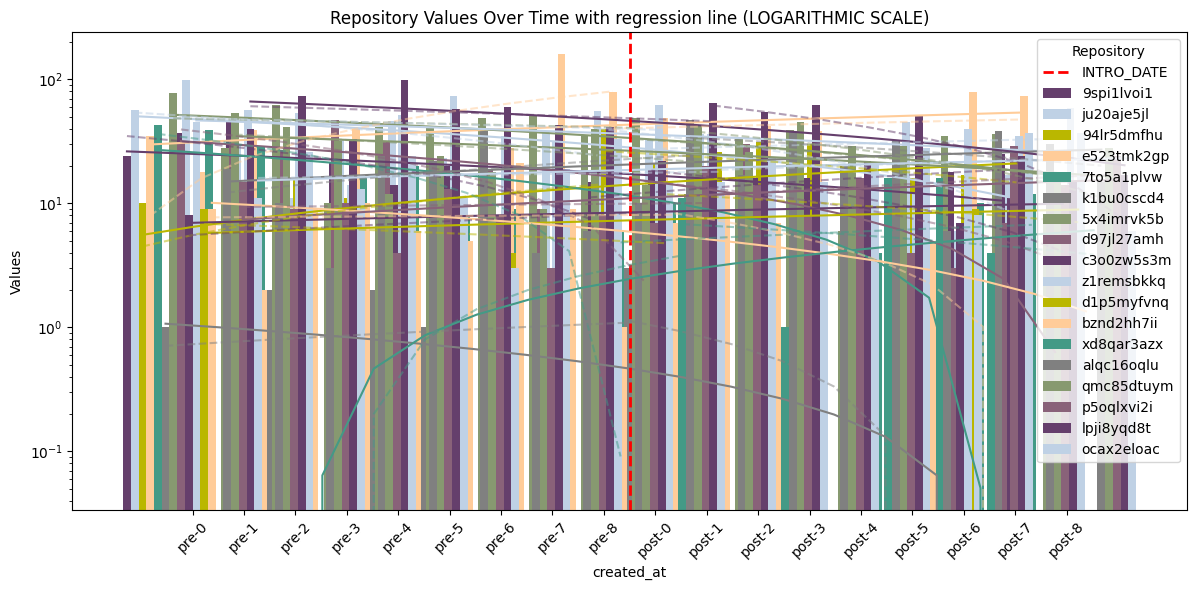

In [53]:
import numpy as np
from scipy.stats import linregress

tangent_data = []

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in commit_result_df.columns if col != 'repository']
colors = ["#FF4500", "#FFA500", "#FF8C00", "#FFD700", "#FF6347", "#FF7F50", "#FFB347", "#FFCC99"]
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#FFCC99", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(commit_result_df['repository']):
    # Extract data for the current repository
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    m, b, _, _, _ = linregress(x, values.values)
    regression_line = m * x + b
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='-', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = commit_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))
    post_0 = 'post-0' if 'post-0' in post_columns else None
    
    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2

        # Vertical red line at midpoint
        plt.axvline(x=midpoint + (len(commit_result_df['repository']) - 1) * bar_width / 2,
                    color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

# Plot bars and regression lines
for i, repo in enumerate(commit_result_df['repository']):
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)

    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, bar_width, label="_nolegend_", color=colors[i % len(colors)])

    if pre_columns and post_columns and largest_pre and post_0:
        # Indices for regression segments
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Extract values
        pre_values = values.values[pre_range]
        post_values = values.values[post_range]

        # Regression before midpoint
        m_pre, b_pre, *_ = linregress(pre_range, pre_values)
        reg_line_pre = m_pre * pre_range + b_pre
        plt.plot(offset_x[pre_range], reg_line_pre, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Regression after midpoint
        m_post, b_post, *_ = linregress(post_range, post_values)
        reg_line_post = m_post * post_range + b_post
        plt.plot(offset_x[post_range], reg_line_post, linestyle='--', linewidth=1.5,
                color=colors[i % len(colors)], label="_nolegend_", alpha=0.5)

        # Collect regression parameters
        tangent_data.append({
            'repository': repo,
            'm_pre': m_pre,
            'b_pre': b_pre,
            'm_post': m_post,
            'b_post': b_post
        })




# Set x-axis ticks and labels
plt.xticks(x + (len(commit_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
plt.yscale('log')
plt.show()

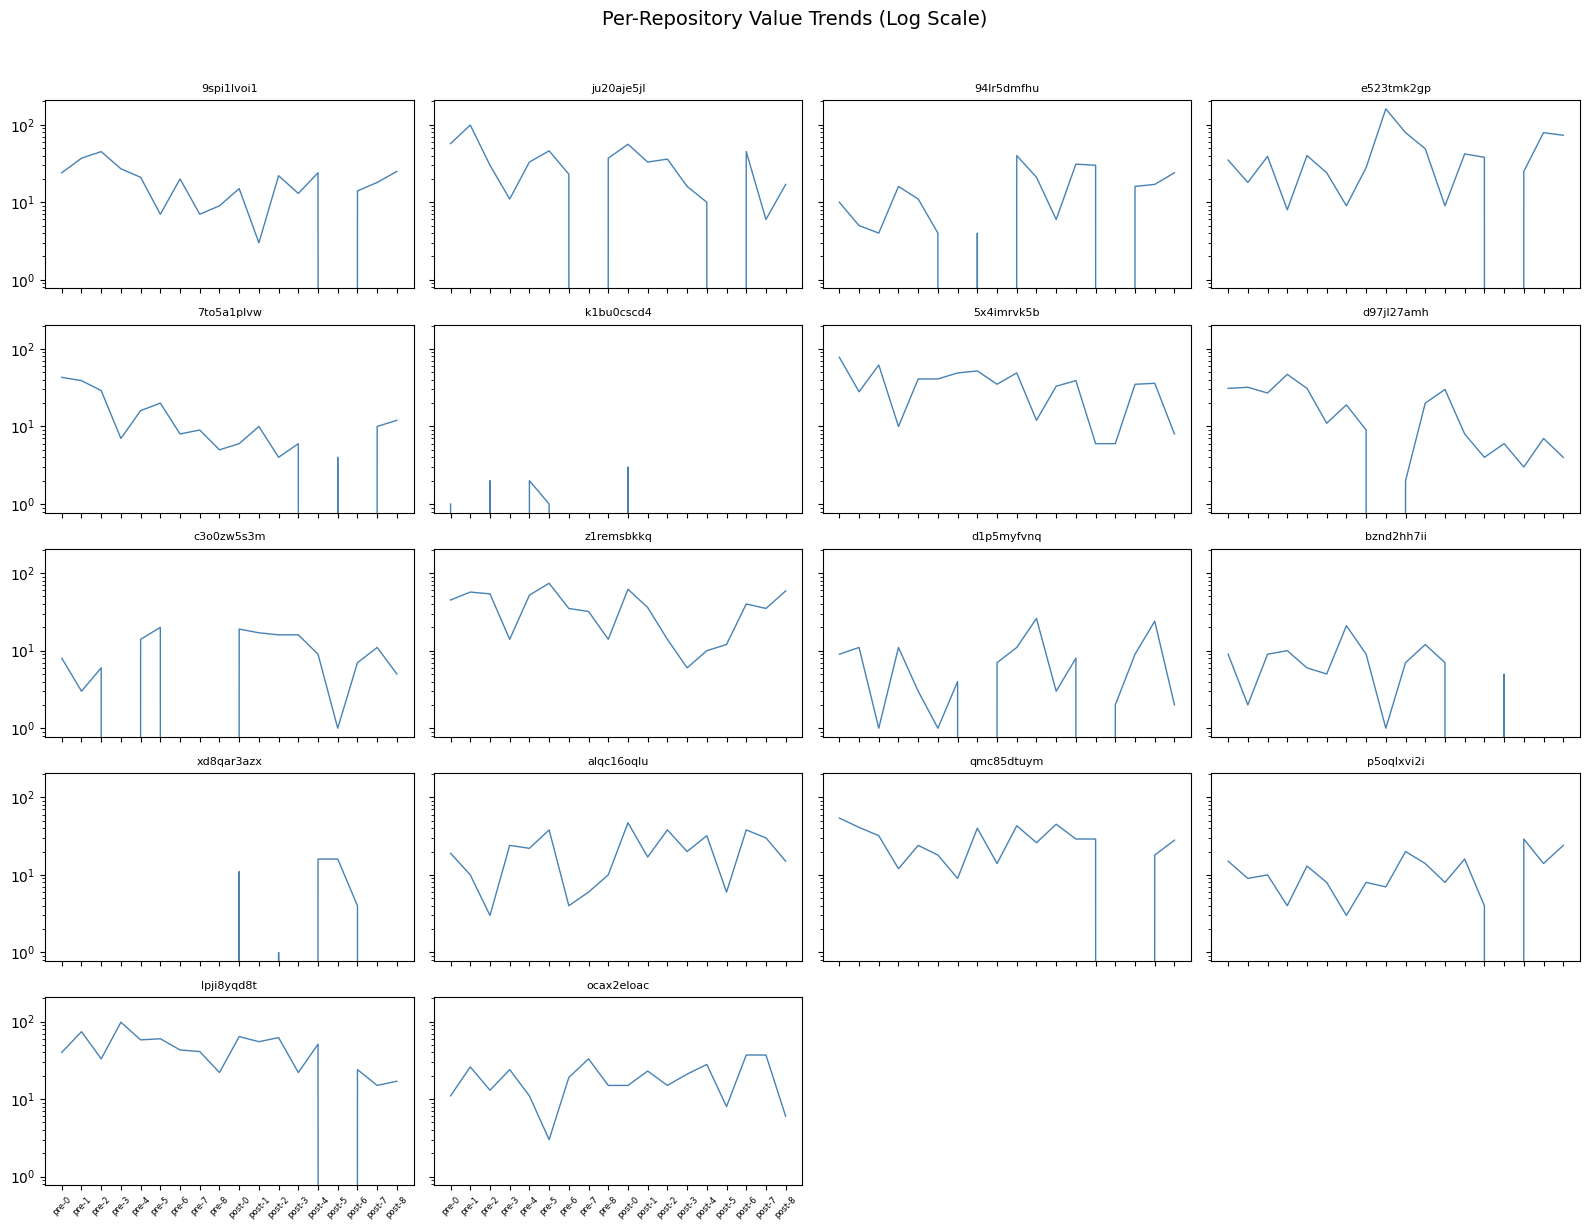

In [54]:
import matplotlib.pyplot as plt

repos = commit_result_df['repository']
date_columns = [col for col in commit_result_df.columns if col != 'repository']
x = np.arange(len(date_columns))

n = len(repos)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 2.5 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, repo in enumerate(repos):
    ax = axes[i]
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    ax.plot(x, values.values, color='steelblue', linewidth=1)
    ax.set_title(repo, fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(date_columns, rotation=45, fontsize=6)
    ax.set_yscale('log')

# Remove unused subplots
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Per-Repository Value Trends (Log Scale)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


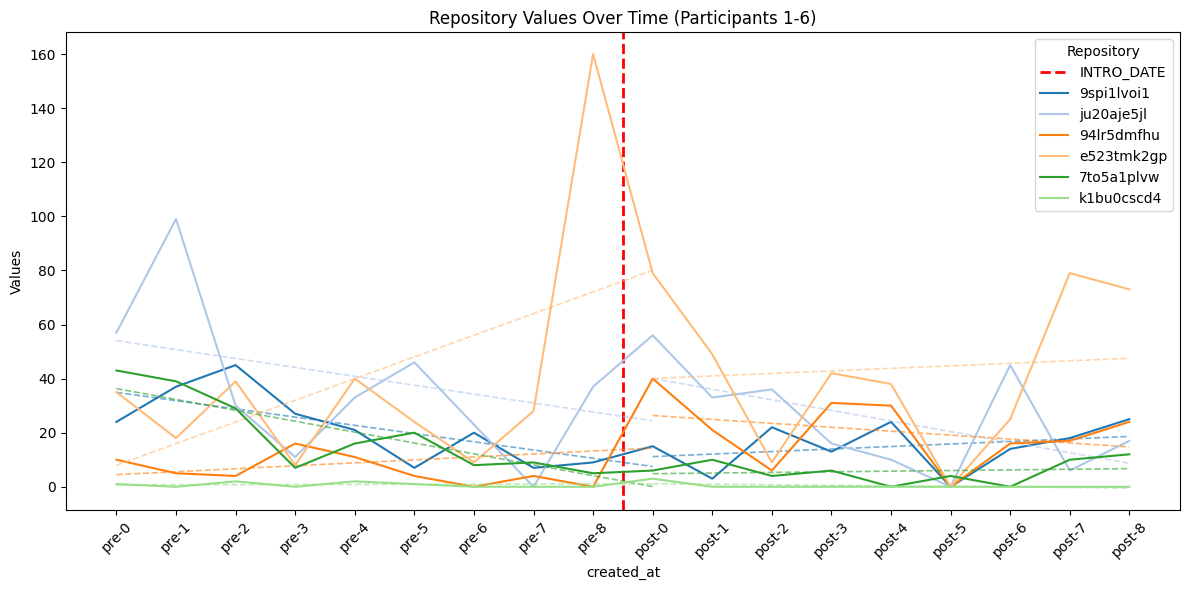

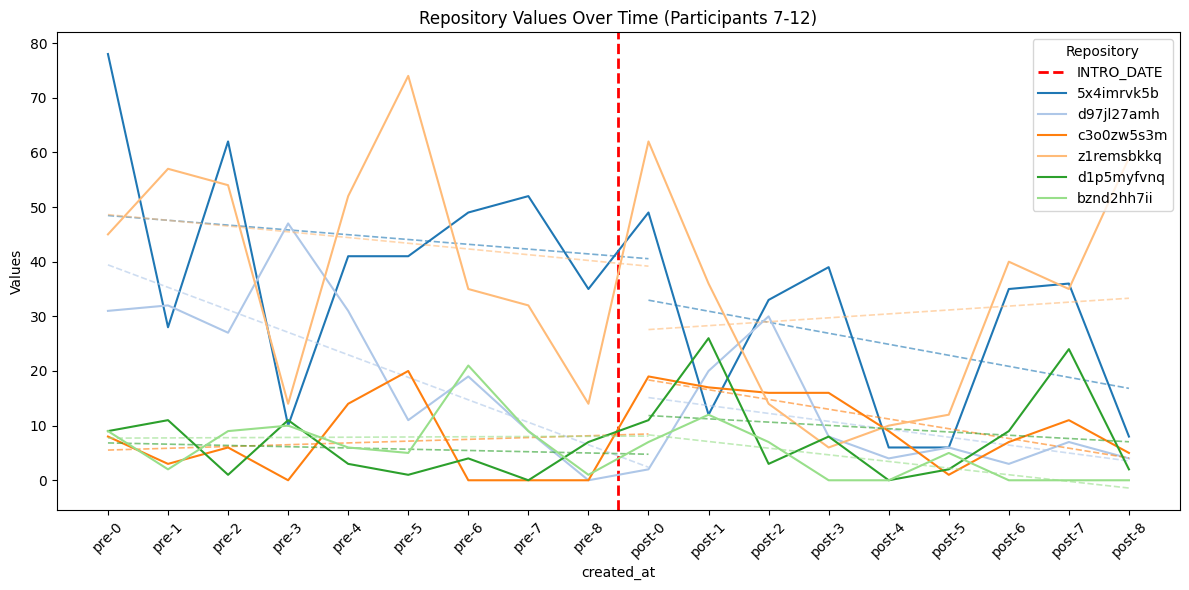

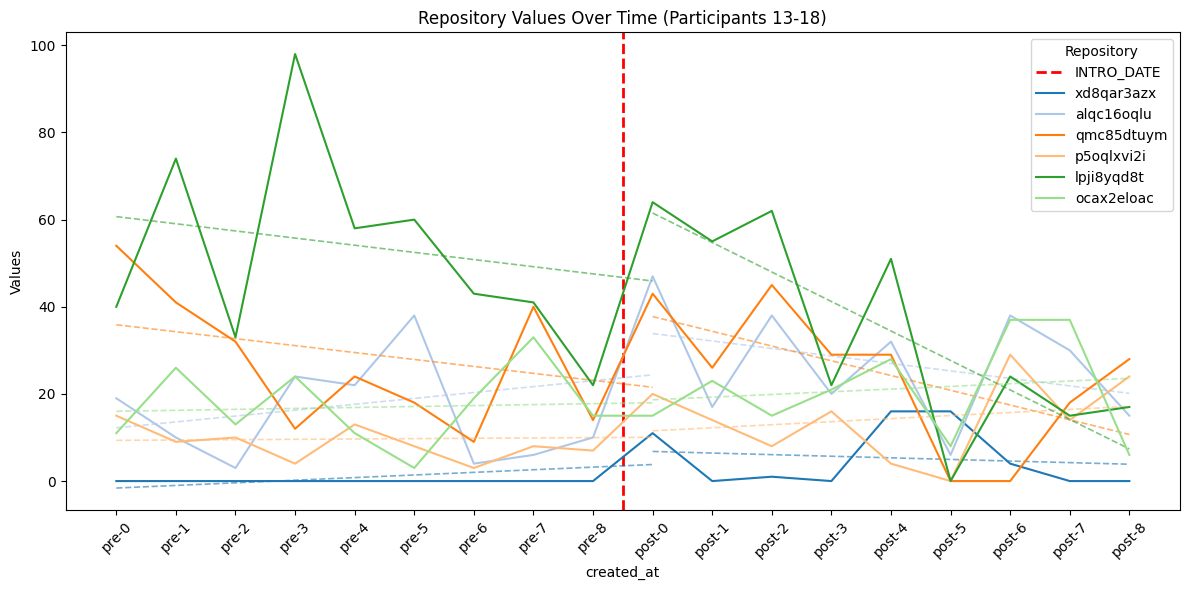

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

colors = plt.cm.tab20.colors
repos = commit_result_df['repository'].tolist()
date_columns = [col for col in commit_result_df.columns if col != 'repository']
x = np.arange(len(date_columns))

pre_columns = [col for col in date_columns if col.startswith('pre-')]
post_columns = [col for col in date_columns if col.startswith('post-')]

# Split into groups of 5
group_size = 6
for group_start in range(0, len(repos), group_size):
    group_repos = repos[group_start:group_start + group_size]
    plt.figure(figsize=(12, 6))
    tangent_data = []

    # Vertical line at introduction date midpoint
    if pre_columns and post_columns:
        largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1]))
        post_0 = 'post-0' if 'post-0' in post_columns else None
        if largest_pre and post_0:
            pre_index = date_columns.index(largest_pre)
            post_0_index = date_columns.index(post_0)
            midpoint = (pre_index + post_0_index) / 2
            plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label="INTRO_DATE")

    for i, repo in enumerate(group_repos):
        values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
        color = colors[i % len(colors)]
        plt.plot(x, values.values, label=repo, color=color, linewidth=1.5)

        if pre_columns and post_columns and largest_pre and post_0:
            pre_range = np.arange(0, post_0_index + 1)
            post_range = np.arange(post_0_index, len(values))
            pre_values = values.values[pre_range]
            post_values = values.values[post_range]
            m_pre, b_pre, *_ = linregress(pre_range, pre_values)
            m_post, b_post, *_ = linregress(post_range, post_values)
            reg_line_pre = m_pre * pre_range + b_pre
            reg_line_post = m_post * post_range + b_post
            plt.plot(pre_range, reg_line_pre, linestyle='--', linewidth=1.2, color=color, alpha=0.6, label="_nolegend_")
            plt.plot(post_range, reg_line_post, linestyle='--', linewidth=1.2, color=color, alpha=0.6, label="_nolegend_")
            tangent_data.append({
                'repository': repo,
                'm_pre': m_pre,
                'b_pre': b_pre,
                'm_post': m_post,
                'b_post': b_post
            })

    plt.xticks(x, date_columns, rotation=45)
    plt.title(f'Repository Values Over Time (Participants {group_start+1}-{min(group_start+group_size, len(repos))})')
    plt.xlabel('created_at')
    plt.ylabel('Values')
    # plt.yscale('log')
    plt.legend(title='Repository')
    plt.tight_layout()
    plt.show()


P2


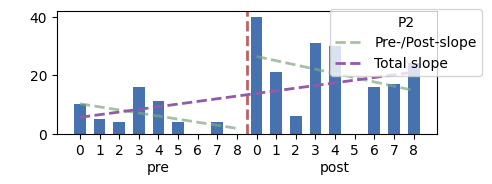

P5


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_58344/3302425262.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.88, 0.88))


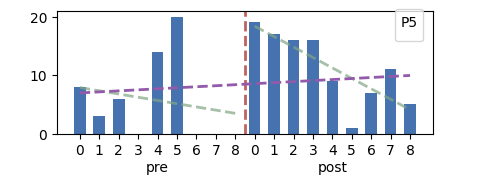

P4


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_58344/3302425262.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.89, 0.88))


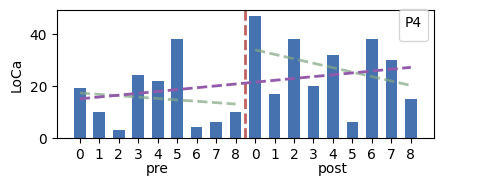

In [65]:
import re 
def compute_slope(row, cols):
    y = row[cols].values.astype(float)
    x = np.arange(len(y))
    
    # Remove NaN values from both x and y
    valid_indices = ~np.isnan(y)
    x = x[valid_indices]
    y = y[valid_indices]
    
    # Check if there are enough points to calculate a slope
    if len(y) < 2:
        return np.nan  # Not enough data points to calculate a slope
    
    return np.polyfit(x, y, 1)[0]

for i, repo in enumerate(commit_result_df['repository']):
    if mapping[repo]['SYNONYM'] not in ['P2', 'P4', 'P5']:
        continue
    values = commit_result_df[commit_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    print(repo)
    plt.figure(figsize=(5, 2))
    offset_x = x + i * bar_width
    plt.bar(offset_x, values.values, 0.6, color='#4672AF')
    plt.rcParams.update({'font.size': 10})
    # Find pre and post columns
    pre_columns = [col for col in date_columns if col.startswith('pre-')]
    post_columns = [col for col in date_columns if col.startswith('post-')]
    largest_pre = max(pre_columns, key=lambda c: int(c.split('-')[1])) if pre_columns else None
    post_0 = 'post-0' if 'post-0' in post_columns else None

    if largest_pre and post_0:
        pre_index = date_columns.index(largest_pre)
        post_0_index = date_columns.index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint + i * bar_width, color='#BD6261', linestyle='--', linewidth=2)

        # Pre and post ranges
        pre_range = np.arange(0, post_0_index + 1)
        post_range = np.arange(post_0_index, len(values))

        # Pre and post regression using compute_slope
        pre_cols = date_columns[0:post_0_index]
        post_cols = date_columns[post_0_index:]

        if len(pre_cols) > 1:
            m_pre = compute_slope(values, pre_cols)
            b_pre = np.polyfit(np.arange(len(pre_cols)), values[pre_cols].values, 1)[1]
            reg_line_pre = m_pre * np.arange(len(pre_cols)) + b_pre
            
            if mapping[repo]['SYNONYM'] == 'P2':
                plt.plot(offset_x[:len(pre_cols)], reg_line_pre, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="Pre-/Post-slope")
            else:
                plt.plot(offset_x[:len(pre_cols)], reg_line_pre, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="")
        if len(post_cols) > 1:
            m_post = compute_slope(values, post_cols)
            b_post = np.polyfit(np.arange(len(post_cols)), values[post_cols].values, 1)[1]
            reg_line_post = m_post * np.arange(len(post_cols)) + b_post
            plt.plot(offset_x[post_0_index:post_0_index+len(post_cols)], reg_line_post, linestyle='--', linewidth=2, color='#81A684', alpha=0.7, label="")

    # Overall regression (dashed, black) using compute_slope
    m_total = compute_slope(values, date_columns)
    if not np.isnan(m_total):
        b_total = np.polyfit(np.arange(len(date_columns)), values[date_columns].values, 1)[1]
        regression_line = m_total * np.arange(len(date_columns)) + b_total
        
        if mapping[repo]['SYNONYM'] == 'P2':
            plt.plot(offset_x, regression_line, color="#9359AA", linestyle='--', linewidth=2, label="Total slope")
        else:
            plt.plot(offset_x, regression_line, color='#9359AA', linestyle='--', linewidth=2, label="")

    # Custom x-tick labels: only numbers
    tick_numbers = [int(re.search(r'-(\d+)', col).group(1)) for col in date_columns]
    plt.xticks(offset_x, tick_numbers, rotation=0)

    # Add 'pre' and 'post' labels below the numbers
    pre_len = len([col for col in date_columns if col.startswith('pre-')])
    post_len = len([col for col in date_columns if col.startswith('post-')])
    y_min, y_max = plt.ylim()
    
    if mapping[repo]['SYNONYM'] == 'P5':
        y_label = -4.5  # Place below x-axis
    else:
        y_label = -9  # Place below x-axis
    if pre_len > 0:
        plt.text(np.mean(offset_x[:pre_len]), y_label, 'pre', ha='center', va='top', fontsize=10)
    if post_len > 0:
        plt.text(np.mean(offset_x[pre_len:]), y_label, 'post', ha='center', va='top', fontsize=10)

    plt.title('')
    plt.xlabel('')
    if mapping[repo]['SYNONYM'] == 'P4':
        plt.ylabel('LoCa')
    else:
        plt.ylabel('LoCa', color='white')
    
    if mapping[repo]['SYNONYM'] == 'P2':
        plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.7, 0.74))
    else:
        if mapping[repo]['SYNONYM'] == 'P5':
            plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.88, 0.88))
            plt.text(19.45, 14.8, '  slope', fontdict={'fontsize': 10, 'color': 'white'})
        else:
            plt.legend(title=mapping[repo]['SYNONYM'], loc='center left', bbox_to_anchor=(0.89, 0.88))
            plt.text(20.15, 14.8, '  slope', fontdict={'fontsize': 10, 'color': 'white'})
    plt.tight_layout()
    
    if mapping[repo]['SYNONYM'] in ['P2', 'P4', 'P5']:
        save_dir = os.path.dirname(storage_path)
        pdf_path = f"{save_dir}/{mapping[repo]['SYNONYM']}.pdf"
        plt.savefig(pdf_path)
    
    plt.show()

# Significancetest 

In [ ]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the commit_result_df
commit_result_df = commit_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in commit_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in commit_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(commit_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

    repository  pre_p_value  after_p_value  pre_normal  after_normal
0   P3     0.421926   3.580477e-01        True          True
1   P9     0.458066   6.549284e-01        True          True
2   P2     0.257905   9.661779e-01        True          True
3   P8     0.000242   4.355977e-01       False          True
4   P1     0.142811   4.397064e-01        True          True
5   k1bu0cscd4     0.005206   3.217493e-07       False         False
6   5x4imrvk5b     0.994132   8.602698e-02        True          True
7   P7     0.797802   5.398138e-03        True         False
8   P5     0.034442   5.690820e-01       False          True
9   P14     0.668170   2.067886e-01        True          True
10  P6     0.194915   5.707128e-02        True          True
11  bznd2hh7ii     0.125018   1.284907e-02        True         False
12  xd8qar3azx     1.000000   5.142154e-03        True         False
13  P4     0.276639   8.537028e-01        True          True
14  P13     0.500727   2.170219e-01        T

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
# significance_results_df = use_normality_results_for_significance_independent(normality_results, commit_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)

from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(commit_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

    repository      test_used  effect_size  ci_lower  ci_upper
0   P3  Cliff's Delta    -0.296296 -0.753704  0.283951
1   P9  Cliff's Delta    -0.283951 -0.753086  0.247222
2   P2  Cliff's Delta     0.716049  0.209877  1.000000
3   P8  Cliff's Delta     0.271605 -0.284568  0.802469
4   P1  Cliff's Delta    -0.654321 -0.950617 -0.209877
5   k1bu0cscd4  Cliff's Delta    -0.283951 -0.666667  0.111111
6   5x4imrvk5b  Cliff's Delta    -0.580247 -0.925926 -0.147840
7   P7  Cliff's Delta    -0.604938 -1.000000 -0.061111
8   P5  Cliff's Delta     0.506173  0.012346  0.925926
9   P14  Cliff's Delta    -0.296296 -0.814815  0.271605
10  P6  Cliff's Delta     0.197531 -0.370370  0.728395
11  bznd2hh7ii  Cliff's Delta    -0.543210 -0.925926 -0.037037
12  xd8qar3azx  Cliff's Delta     0.555556  0.222222  0.888889
13  P4  Cliff's Delta     0.493827 -0.037037  0.851852
14  P13  Cliff's Delta    -0.024691 -0.555556  0.580247
15  P12  Cliff's Delta     0.419753 -0.135802  0.889198
16  P10  Cliff's Delta

In [ ]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,24.0,37.0,45.0,27.0,21.0,7.0,20.0,7.0,9.0,...,13.0,24.0,0.0,14.0,18.0,25.0,Cliff's Delta,-0.296296,-0.753704,0.283951
1,P9,57.0,99.0,30.0,11.0,33.0,46.0,23.0,0.0,37.0,...,16.0,10.0,0.0,45.0,6.0,17.0,Cliff's Delta,-0.283951,-0.753086,0.247222
2,P2,10.0,5.0,4.0,16.0,11.0,4.0,0.0,4.0,0.0,...,31.0,30.0,0.0,16.0,17.0,24.0,Cliff's Delta,0.716049,0.209877,1.000000
3,P8,35.0,18.0,39.0,8.0,40.0,24.0,9.0,28.0,160.0,...,42.0,38.0,0.0,25.0,79.0,73.0,Cliff's Delta,0.271605,-0.284568,0.802469
4,P1,43.0,39.0,29.0,7.0,16.0,20.0,8.0,9.0,5.0,...,6.0,0.0,4.0,0.0,10.0,12.0,Cliff's Delta,-0.654321,-0.950617,-0.209877
5,k1bu0cscd4,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.283951,-0.666667,0.111111
6,5x4imrvk5b,78.0,28.0,62.0,10.0,41.0,41.0,49.0,52.0,35.0,...,39.0,6.0,6.0,35.0,36.0,8.0,Cliff's Delta,-0.580247,-0.925926,-0.147840
7,P7,31.0,32.0,27.0,47.0,31.0,11.0,19.0,9.0,0.0,...,8.0,4.0,6.0,3.0,7.0,4.0,Cliff's Delta,-0.604938,-1.000000,-0.061111
8,P5,8.0,3.0,6.0,0.0,14.0,20.0,0.0,0.0,0.0,...,16.0,9.0,1.0,7.0,11.0,5.0,Cliff's Delta,0.506173,0.012346,0.925926
9,P14,45.0,57.0,54.0,14.0,52.0,74.0,35.0,32.0,14.0,...,6.0,10.0,12.0,40.0,35.0,59.0,Cliff's Delta,-0.296296,-0.814815,0.271605


In [ ]:
merged = commit_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-3,post-4,post-5,post-6,post-7,post-8,test_used,effect_size,ci_lower,ci_upper
0,P3,24.0,37.0,45.0,27.0,21.0,7.0,20.0,7.0,9.0,...,13.0,24.0,0.0,14.0,18.0,25.0,Cliff's Delta,-0.296296,-0.753704,0.283951
1,P9,57.0,99.0,30.0,11.0,33.0,46.0,23.0,0.0,37.0,...,16.0,10.0,0.0,45.0,6.0,17.0,Cliff's Delta,-0.283951,-0.753086,0.247222
2,P2,10.0,5.0,4.0,16.0,11.0,4.0,0.0,4.0,0.0,...,31.0,30.0,0.0,16.0,17.0,24.0,Cliff's Delta,0.716049,0.209877,1.000000
3,P8,35.0,18.0,39.0,8.0,40.0,24.0,9.0,28.0,160.0,...,42.0,38.0,0.0,25.0,79.0,73.0,Cliff's Delta,0.271605,-0.284568,0.802469
4,P1,43.0,39.0,29.0,7.0,16.0,20.0,8.0,9.0,5.0,...,6.0,0.0,4.0,0.0,10.0,12.0,Cliff's Delta,-0.654321,-0.950617,-0.209877
5,k1bu0cscd4,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Cliff's Delta,-0.283951,-0.666667,0.111111
6,5x4imrvk5b,78.0,28.0,62.0,10.0,41.0,41.0,49.0,52.0,35.0,...,39.0,6.0,6.0,35.0,36.0,8.0,Cliff's Delta,-0.580247,-0.925926,-0.147840
7,P7,31.0,32.0,27.0,47.0,31.0,11.0,19.0,9.0,0.0,...,8.0,4.0,6.0,3.0,7.0,4.0,Cliff's Delta,-0.604938,-1.000000,-0.061111
8,P5,8.0,3.0,6.0,0.0,14.0,20.0,0.0,0.0,0.0,...,16.0,9.0,1.0,7.0,11.0,5.0,Cliff's Delta,0.506173,0.012346,0.925926
9,P14,45.0,57.0,54.0,14.0,52.0,74.0,35.0,32.0,14.0,...,6.0,10.0,12.0,40.0,35.0,59.0,Cliff's Delta,-0.296296,-0.814815,0.271605


# Interpretation
- 0 -> less commits after introduction
-  3, 4,5 -> more commits after introduction
-  1 less commits